In [1]:
#Here you are an header example
import cl2pd # do "pip install --user git+https://github.com/sterbini/cl2pd.git" to install
from cl2pd import importData
from cl2pd import plotFunctions
from cl2pd import dotdict
from cl2pd import bbFunctions
from cl2pd import variablesDF

dotdict=dotdict.dotdict
pd=importData.pd     # is the pandas package
np=importData.np     # is the numpy package
cals=importData.cals # pytimber log class

import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
%config InlineBackend.figure_format = 'retina' # retina display
mySource='/eos/user/s/sterbini/MD_ANALYSIS/2018/BB encounter schedule/BBEncouterSchedule.ipynb'

# Introduction

In this notebook we weill present some tools for computing the beam-beam encounter schedules in LHC.

This notebook is an implementation of the approach presented in 

https://hackmd.web.cern.ch/xC504CWmQG685DDRwOm3Og

The contribution of **Axel Poyet** was fundamental.

# Step 1: the beam-beam matrix

In [2]:
# First of all, one needs the so called beam-beam matrix. This matrix does not depend on the MAD-X file or by the filling scheme but only of the bucket distance of the IPs in LHC.
myMatrix=bbFunctions.computeBBMatrix(numberOfLRToConsider=25)

In [3]:
fillingSchemeDF=importData.LHCCals2pd(['LHC.BCTFR.A6R4.B%:BUNCH_FILL_PATTERN'],6216, ['FLATTOP'],flag='next') #BB MD 2017
B1_bunches=np.where(fillingSchemeDF.iloc[0]['LHC.BCTFR.A6R4.B1:BUNCH_FILL_PATTERN'])[0]
B2_bunches=np.where(fillingSchemeDF.iloc[0]['LHC.BCTFR.A6R4.B2:BUNCH_FILL_PATTERN'])[0]

In [4]:
B1_bunches

array([  0, 100, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210,
       211, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311,
       312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324,
       325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337,
       338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 400, 401, 402,
       403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415,
       416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428,
       429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441,
       442, 443, 444, 445, 446, 447, 500, 501, 502, 503, 504, 505, 506,
       507, 512, 513, 514, 515, 516, 517, 518, 519, 524, 525, 526, 527,
       528, 529, 530, 531, 536, 537, 538, 539, 540, 541, 542, 543, 548,
       549, 550, 551, 552, 553, 554, 555, 560, 561, 562, 563, 564, 565,
       566, 567, 572, 573, 574, 575, 576, 577, 578, 579])

In [5]:
B2_bunches

array([ 20, 100, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210,
       211, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311,
       312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324,
       325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337,
       338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 400, 401, 402,
       403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415,
       416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428,
       429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441,
       442, 443, 444, 445, 446, 447, 500, 501, 502, 503, 504, 505, 506,
       507, 512, 513, 514, 515, 516, 517, 518, 519, 524, 525, 526, 527,
       528, 529, 530, 531, 536, 537, 538, 539, 540, 541, 542, 543, 548,
       549, 550, 551, 552, 553, 554, 555, 560, 561, 562, 563, 564, 565,
       566, 567, 572, 573, 574, 575, 576, 577, 578, 579])

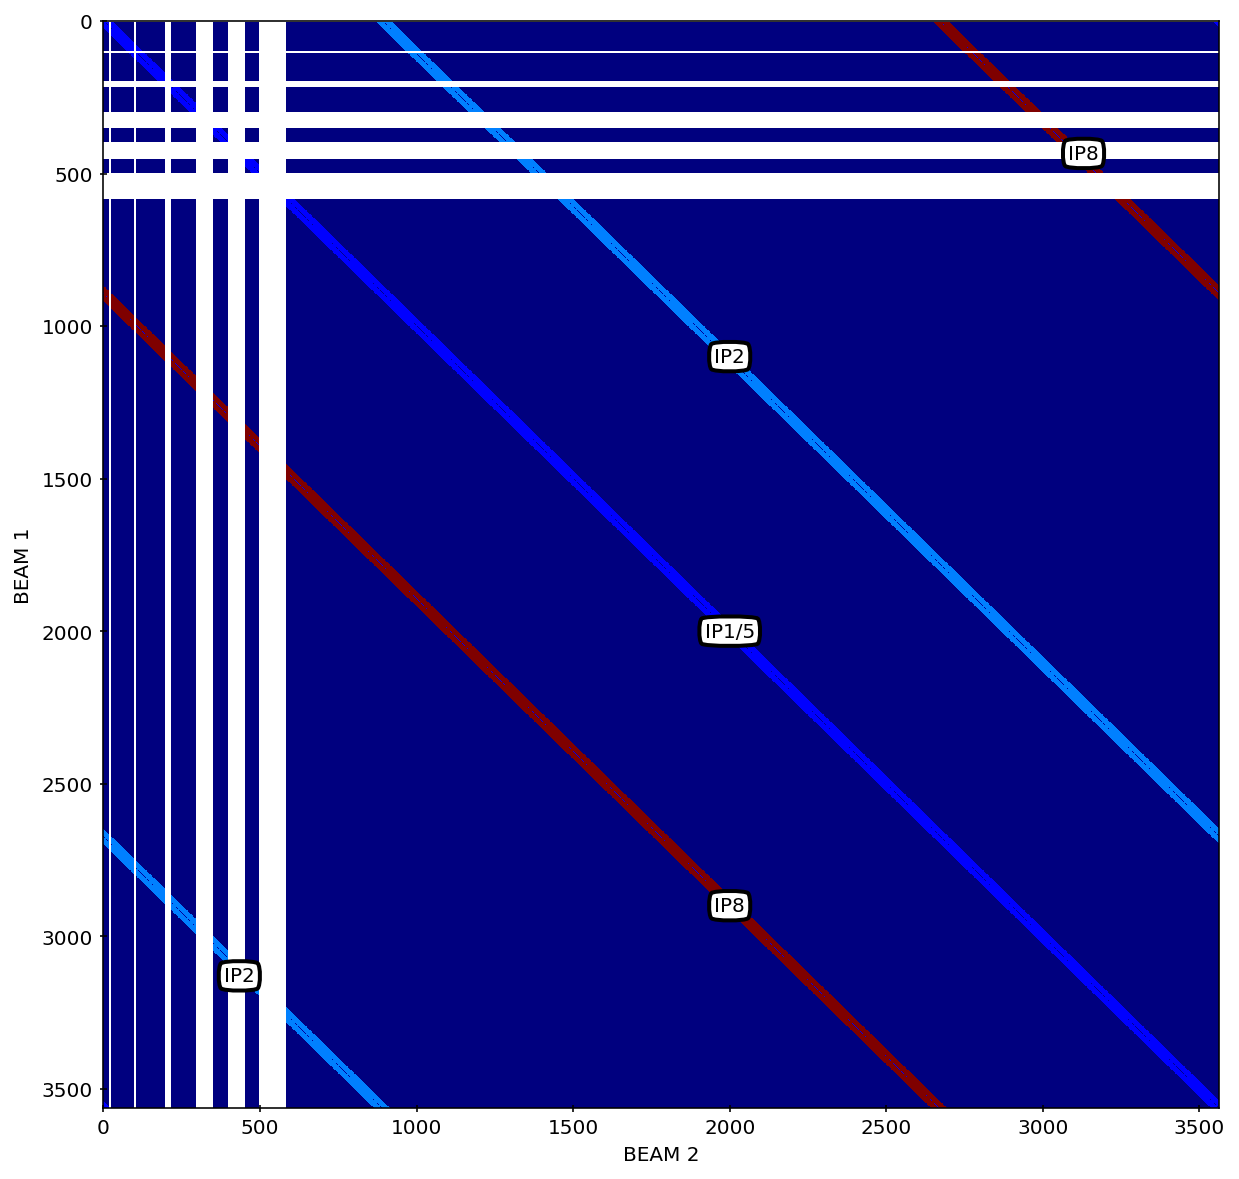

In [6]:
plotFunctions.plot_BBMatrix(myMatrix,B1_bunches,B2_bunches, alpha=1)

## Step 2: Beam BB pattern
Now, we will consider the filling scheme. The idea is therefore to filter the previous results, with the filling scheme, in order to obtain the real BB pattern for one given bunch of one given beam in one given experiment.

As an output, we will have, for one bunch of one beam in one experiment, the bunch numbers of all the encounters (HO+LR) and their relative position wrt the IP (ie, where does our bunch meet this particular encounter?).

In [7]:
# Definition of a NAIVE filling scheme
B1_bunches=np.array([0,1,2])
B2_bunches=np.array([0,1,2])
results=bbFunctions.BBEncounterSchedule(B1_bunches, B2_bunches, myMatrix) # this is a dotdict (a special dictionary)

In [11]:
results.atB1.at0000.atCMS

{'atEncounters': array([0, 1, 2]), 'atPositions': array([0, 1, 2])}

In [13]:
pd.DataFrame(results.atB1.at0001)# it is very easy to cast a dictionary in a pd.Dataframe

,atALICE,atATLAS,atCMS,atLHCB
atEncounters,[],"[0, 1, 2]","[0, 1, 2]",[]
atPositions,[],"[-1, 0, 1]","[-1, 0, 1]",[]


In [14]:
pd.DataFrame(results.atB2.at0000)

,atALICE,atATLAS,atCMS,atLHCB
atEncounters,[],"[2, 1, 0]","[2, 1, 0]",[]
atPositions,[],"[-2, -1, 0]","[-2, -1, 0]",[]


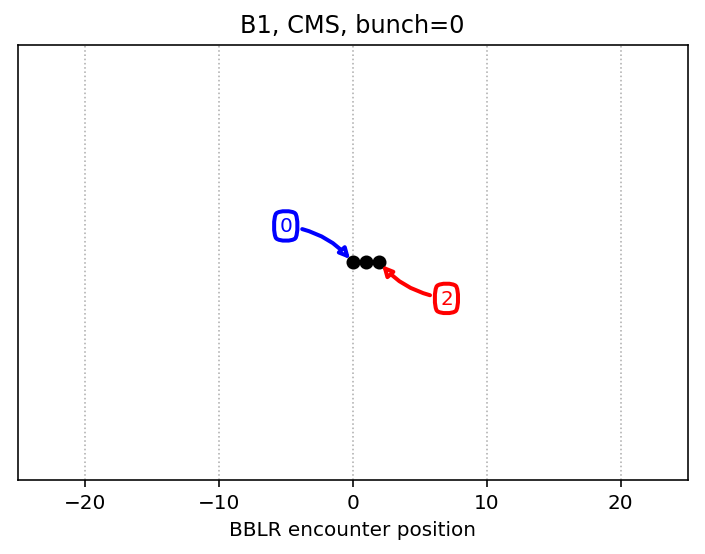

In [16]:
# Visualizing the BB encounter schedule
plotFunctions.plotBBEncounterSchedule(results,beam='atB1',exp='atCMS',bunch=0)

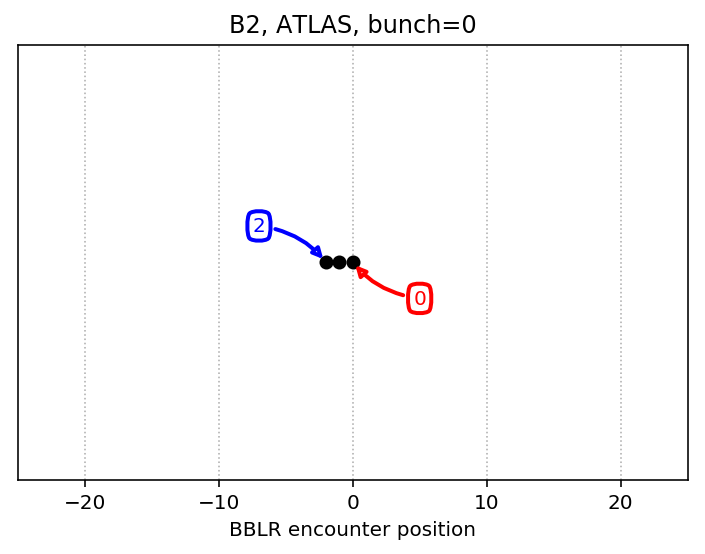

In [17]:
plotFunctions.plotBBEncounterSchedule(results,beam='atB2',exp='atATLAS',bunch=0)

In [20]:
# Definition of a realistic filling scheme (this can take ~1 minute)
fillingSchemeDF=importData.LHCCals2pd(['LHC.BCTFR.A6R4.B%:BUNCH_FILL_PATTERN'],6666, ['FLATTOP'],flag='next')
B1_bunches=np.where(fillingSchemeDF.iloc[0]['LHC.BCTFR.A6R4.B1:BUNCH_FILL_PATTERN'])[0]
B2_bunches=np.where(fillingSchemeDF.iloc[0]['LHC.BCTFR.A6R4.B2:BUNCH_FILL_PATTERN'])[0]
results=bbFunctions.BBEncounterSchedule(B1_bunches, B2_bunches, myMatrix)

In [21]:
pd.DataFrame(results.atB1.at0042)

,atALICE,atATLAS,atCMS,atLHCB
atEncounters,"[919, 920, 921, 922, 923, 924, 925, 926, 927, ...","[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]","[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]","[2707, 2708, 2709, 2710, 2711, 2712, 2713, 271..."
atPositions,"[-14, -13, -12, -11, -10, -9, -8, -7, -6, -5, ...","[-17, -16, -15, -14, -13, -12, -11, -10, -9, -...","[-17, -16, -15, -14, -13, -12, -11, -10, -9, -...","[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8..."


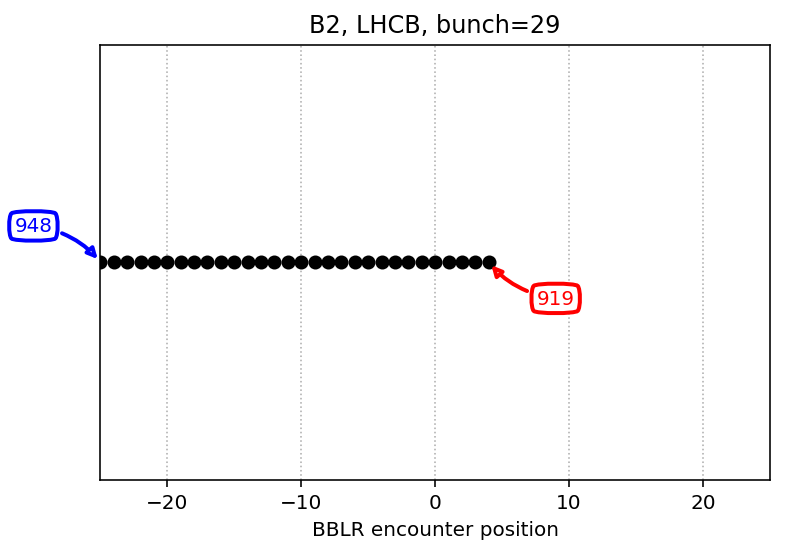

In [23]:
plotFunctions.plotBBEncounterSchedule(results,beam='atB2',exp='atLHCB',bunch=29)